In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import torch
import torch.nn.functional as F
import torchtext as tt

from livelossplot import PlotLosses
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

Code based on:
1. https://www.analyticsvidhya.com/blog/2019/01/guide-pytorch-neural-networks-case-studies/#
2. http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

with some small improvements.

# SpaCy

To tokenize sentences we will use SpaCy.

In [2]:
nlp = spacy.load('en')

In [3]:
def tokenize(sentence, nlp):
    return [token.text for token in nlp.tokenizer(sentence)]


tokenize_en = lambda sentence: tokenize(sentence, nlp=nlp)

An example how it works in practice

In [4]:
tokenize_en('A simple test of a tokenizer.')

['A', 'simple', 'test', 'of', 'a', 'tokenizer', '.']

# Data preparation

## Getting data

Sentiment data taken from [here](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/train.csv).

In [5]:
# !wget https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/train.csv -O data/sentiment.csv

Let's load it and see how it looks like.

In [6]:
sentiment = pd.read_csv('data/sentiment.csv')
sentiment.columns = [c.strip() for c in sentiment.columns]
sentiment.head()

,text,label
0,A very very very slow-moving aimless movie ...,0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
print('There are {} labelled sentences'.format(len(sentiment)))

There are 748 labelled sentences


## Preparing data

Loaded data is now split into train, test, val sets, which are then saved to separate files.

In [8]:
train, test = train_test_split(sentiment, test_size=0.1, random_state=3445)

In [9]:
train, val = train_test_split(train, test_size=0.1, random_state=2434)

In [10]:
list(map(len, (train, val, test)))

[605, 68, 75]

Saving each dataset to a separate file, to facilitate `TabularDataset` functionality.

In [11]:
train.to_csv('data/train.csv', index=False)
val.to_csv('data/val.csv', index=False)
test.to_csv('data/test.csv', index=False)

In [12]:
TEXT = tt.data.Field(sequential=True, tokenize=tokenize_en, lower=True)
LABEL = tt.data.Field(sequential=False, use_vocab=False)

In [13]:
data_fields = [('text', TEXT), ('label', LABEL)]
train, val, test = tt.data.TabularDataset.splits(
    path='data/',
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    format='csv',
    fields=data_fields,
    skip_header=True)

File with GloVe vectors. I used the small one, `glove.6B.50d.tx`.

In [14]:
EMBEDDING_FILE = '/Users/qoqosz/Downloads/glove.6B/glove.6B.50d.txt'

In [15]:
vec = tt.vocab.Vectors(EMBEDDING_FILE)

Building vocabulary without test dataset.

In [16]:
TEXT.build_vocab(train, val, max_size=1000, vectors=vec, min_freq=3)

In [17]:
TEXT.vocab.stoi['great']

54

TorchText iterators over the dataset.

In [18]:
train_iter, val_iter, test_iter = tt.data.BucketIterator.splits(
    (train, val, test),
    batch_sizes=(32, 32, 32),
    shuffle=False,
    sort_key=lambda x: len(x.text),
    sort_within_batch=False,
    repeat=False)

BatchWrapper - Data Loader

In [19]:
class BatchWrapper(object):
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var)

            if self.y_vars is not None:
                y = torch.cat([getattr(batch, feat) 
                               for feat in self.y_vars]).float()
            else:
                y = torch.zeros((1))

            yield (x, y)

    def __len__(self):
        return len(self.dl)

Model parameters

In [20]:
vocab_size = len(TEXT.vocab)
embedding_dim = 50
n_hidden = 32
len(TEXT.vocab)

680

Define DataLoaders

In [21]:
train_dl = BatchWrapper(train_iter, 'text', ['label'])
val_dl = BatchWrapper(val_iter, 'text', ['label'])
test_dl = BatchWrapper(test_iter, 'text', ['label'])

The model

In [22]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, pretrained_vec):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden

        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, 
                                      embedding_dim=self.embedding_dim)
        # load pretrained vectors
        self.embedding.weight.data.copy_(pretrained_vec)
        # don't update loaded vectors
        self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=n_hidden)
        self.linear = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, 1)

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        max_pool, _ = torch.max(h_lstm, 0)
        linear = self.linear(max_pool)
        output = torch.sigmoid(self.out(linear))

        return output

In [23]:
model = Model(vocab_size, embedding_dim, n_hidden, TEXT.vocab.vectors)

## Train

In [24]:
loss_function = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters())

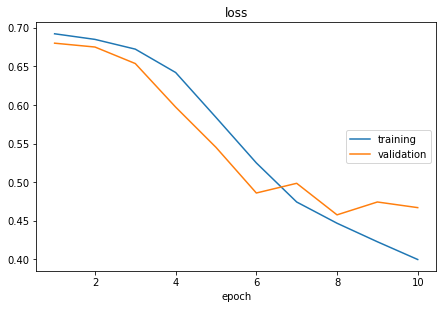

loss:
training   (min:    0.400, max:    0.692, cur:    0.400)
validation (min:    0.458, max:    0.680, cur:    0.467)


In [25]:
n_epoch = 10
dl = {'train': train_dl, 'validation': val_dl}
liveloss = PlotLosses()

for epoch in range(1, n_epoch + 1):
    logs = {}
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        phase_loss = []
            
        for x, y in dl[phase]:
            output = model(x)
            loss = loss_function(output, y.view(-1, 1))
            
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
              
            phase_loss.append(loss.item())
            
        prefix = 'val_' if phase == 'validation' else ''
        logs[prefix + 'loss'] = np.mean(phase_loss)

    liveloss.update(logs)
    liveloss.draw()

Depending on the data, model tends to overfit quite quickly. Definitely it's not a reliable architecture.

# Evaluation

In [34]:
pred, y_true = [], []

for x, y in test_dl:
    output = model(x)
    pred.extend(output.view(-1).tolist())
    y_true.extend(y.tolist())

## ROC

In [27]:
fpr, tpr, _ = roc_curve(y_true, pred)
roc_auc = auc(fpr, tpr)

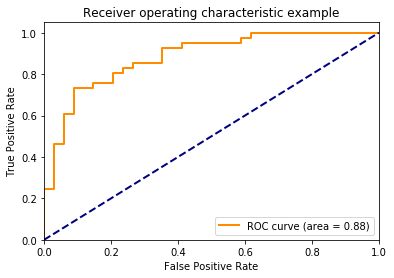

In [28]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [29]:
for i in [0.0, 1.0]:
    print('Label', i, 'count:', (np.array(y_true) == i).sum())

Label 0.0 count: 34
Label 1.0 count: 41


In [30]:
(pd.DataFrame({'y_true': y_true, 'pred': pred})
   .transpose()
   .style.format('{:.2f}'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
y_true,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00
pred,0.03,0.33,0.39,0.31,0.61,0.39,0.56,0.37,0.83,0.13,0.02,0.04,0.75,0.48,0.58,0.43,0.48,0.04,0.51,0.09,0.69,0.51,0.06,0.03,0.76,0.28,0.62,0.31,0.56,0.65,0.06,0.42,0.21,0.21,0.18,0.70,0.83,0.24,0.48,0.95,0.15,0.43,0.73,0.23,0.27,0.71,0.06,0.82,0.96,0.29,0.67,0.56,0.68,0.52,0.94,0.19,0.07,0.87,0.05,0.78,0.74,0.55,0.79,0.32,0.84,0.03,0.65,0.41,0.92,0.63,0.53,0.47,0.68,0.45,0.46


# Custom prediction

Based on oour trained model, let's see how it can handle custom user input.

In [31]:
def predict(sent):
    """Possible improvement - a list of sentences as the argument."""
    tokens = tokenize_en(sent.lower())
    x = torch.LongTensor([TEXT.vocab.stoi[t] for t in tokens])
    prediction = model(x.view(-1, 1)).item()
    
    return prediction

In [32]:
sents = [
    "This model's performance seems to be pretty decent!",
    'Oh, bloody hell!',
    "Nah, I'm not impressed",
    "I'm in heaven",
    "Good job",
    "Bad job",
    'The result is fairly ok'
]

In [33]:
pd.DataFrame({'pred': list(map(predict, sents)), 'sentence': sents})

,pred,sentence
0,0.662333,This model's performance seems to be pretty de...
1,0.293115,"Oh, bloody hell!"
2,0.281149,"Nah, I'm not impressed"
3,0.397662,I'm in heaven
4,0.668841,Good job
5,0.026094,Bad job
6,0.395844,The result is fairly ok


Todo: how to use PyTorch/TorchText to plug in all inputs at once to the model?